In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dataset import *
from torch.utils.data import DataLoader
from diffusion import *
from net_b import *
from tqdm import tqdm
import pandas as pd
from vit_min_max import *
import torch.nn.init as init
from collections import OrderedDict
from torchinfo import summary

In [4]:
train=np.load("./train_list_nn_90.npy",allow_pickle=True)
train_list = [i.replace("./","../") for i in train]
test=np.load("./test_list_nn_90.npy",allow_pickle=True)
test_list = [i.replace("./","../") for i in test]
print(len(train_list),len(test_list))       
print(train_list[0],test_list[0])
test_out_dist= glob2.glob("../results_8/**")
print(len(test_out_dist))


39800 9950
../results_new_new/0.425_0.35_0.5_0.0_3_0_300.0.npy ../results_new_new/0.425_0.5_0.3666666666666667_0.0_7_0_133.33333333333334.npy
10850


In [3]:
train_min_max=[]

for i in tqdm(train_list):
    data=np.load(i)
    train_min_max.append([data[-1].min(),data[-1].max(),i])

  0%|          | 0/39800 [00:00<?, ?it/s]

In [4]:
test_min_max=[]
for i in tqdm(test_list):
    data=np.load(i)
    test_min_max.append([data[-1].min(),data[-1].max(),i])

  0%|          | 0/9950 [00:00<?, ?it/s]

In [ ]:
test_outa_min_max=[]
for i in tqdm(test_out_dist):
    data=np.load(i)
    test_outa_min_max.append([data[-1].min(),data[-1].max(),i])

In [5]:
test_df=pd.DataFrame(test_min_max,columns=["min","max","path"])
train_df=pd.DataFrame(train_min_max,columns=["min","max","path"])
test_out_df=pd.DataFrame(test_outa_min_max,columns=["min","max","path"])

NameError: name 'test_outa_min_max' is not defined

<Axes: >

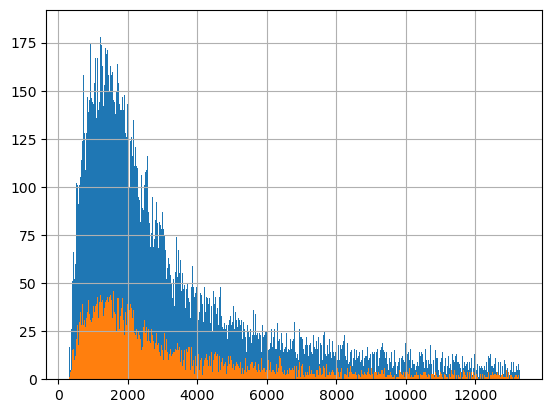

In [ ]:
train_df["max"].hist(bins=1000)
test_df["max"].hist(bins=1000)
test_out_df["max"].hist(bins=1000)

# VIT validation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from dataset import *
from torch.utils.data import DataLoader
from diffusion import *
from net_b import *
from tqdm import tqdm
import pandas as pd
from vit_min_max import *
import torch.nn.init as init
from collections import OrderedDict

In [5]:
train=np.load("train_list_nn_90.npy",allow_pickle=True)
train_list = [i.replace("./","../") for i in train]
test=np.load("test_list_nn_90.npy",allow_pickle=True)
test_list = [i.replace("./","../") for i in test]
print(len(train_list),len(test_list))       
print(train_list[0],test_list[0])
test_out_dist= glob2.glob("../results_8/**")
print(len(test_out_dist))


39800 9950
../results_new_new/0.425_0.35_0.5_0.0_3_0_300.0.npy ../results_new_new/0.425_0.5_0.3666666666666667_0.0_7_0_133.33333333333334.npy
10850


In [17]:
batch_size=50 
dataset_test=DataSet_hyper(test_list)
dataset_test_outa=DataSet_hyper(test_out_dist)
dataset_train=DataSet_hyper(train_list)
test_loader=DataLoader(dataset_test,batch_size=batch_size,shuffle=True,pin_memory=True)
test_loader_outa=DataLoader(dataset_test_outa,batch_size=batch_size,shuffle=True,pin_memory=True)
train_loader=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,pin_memory=True)


net=VisionTransformer(embed_dim=256,hidden_dim=512,num_heads=8,num_layers=16,num_channels=2,patch_size=4,num_patches=256).to("cuda:0") 


model_load=torch.load("./models/vit_min_max_clip_L1_run_new_new_data_2.pth",map_location=torch.device('cuda:0'))

new_state_dict = OrderedDict()

for k, v in model_load["model_state_dict"].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

net.load_state_dict(new_state_dict)
net.eval()

#summary of vit
input1 = torch.randn(1, 2, 64, 64)
input2 = torch.randn(1, 4)
summary(net, [(1,2, 64, 64), (1,4,)], device="cpu")

num_params = sum(p.numel() for p in net.parameters())
print("Number of parameters:", num_params)

Number of parameters: 10747754


In [7]:
vit_results=[]

with torch.no_grad():
    for inputs,targets,targets_n,maxx,minn,stack,f_s in tqdm(test_loader):
        inputs=inputs.to("cuda:0").float()
        stack=stack.to("cuda:0").float()

        f_s=f_s.to("cuda:0").float()
        print(inputs.shape,f_s.shape)

        outputs=net(inputs,f_s)

        outputs=outputs.squeeze(0).squeeze(0).detach().cpu().numpy()
        stack=stack.squeeze(0).detach().cpu().numpy()

        vit_results.append([outputs,stack])
        print(outputs[0],stack[0])
        break

  0%|          | 0/199 [00:00<?, ?it/s]

torch.Size([50, 2, 64, 64]) torch.Size([50, 4])
[5.4209272e+03 8.7029450e-02] [5445.5024    0.    ]


In [44]:
vit_res_arr=np.array(vit_results)
vit_res_arr[0][0][0],vit_res_arr[0][1][0]

(array([5.5786777e+03, 9.2972837e-02], dtype=float32),
 array([5585.6787,    0.    ], dtype=float32))

In [45]:
mae_max=np.abs(maxx-true_max)
maxx,true_max

NameError: name 'true_max' is not defined

# Diffusion validation


In [19]:
batch_size=1 
dataset_test=DataSet_hyper(test_list)
dataset_test_outa=DataSet_hyper(test_out_dist)
dataset_train=DataSet_hyper(train_list)
test_loader=DataLoader(dataset_test,batch_size=batch_size,shuffle=True,pin_memory=True)
test_loader_outa=DataLoader(dataset_test_outa,batch_size=batch_size,shuffle=True,pin_memory=True)
train_loader=DataLoader(dataset_train,batch_size=batch_size,shuffle=True,pin_memory=True)

diff=GaussianDiffusion(Unet(dim=64,dim_mults=(1,1,2,2,4)),image_size=64,p2_loss_weight_k=0,timesteps=500,loss_type="l1",train=False).to("cuda:0")
model_load=torch.load("./models/diff_64_11224_T500_run2_rev.pth")


net=VisionTransformer(embed_dim=256,hidden_dim=512,num_heads=8,num_layers=16,num_channels=2,patch_size=4,num_patches=256).to("cuda:0") 
model_load_vit=torch.load("./models/vit_min_max_clip_L1_run_new_new_data_3.pth",map_location=torch.device('cuda:0'))


new_state_dict = OrderedDict()
new_state_dict_vit = OrderedDict()

for k, v in model_load["model_state_dict"].items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

for k, v in model_load_vit["model_state_dict"].items():
    name = k[7:] # remove `module.`
    new_state_dict_vit[name] = v

diff.load_state_dict(new_state_dict)
net.load_state_dict(new_state_dict_vit)

num_params = sum(p.numel() for p in diff.parameters())
print("Number of parameters:", num_params)

for inputs,targets,targets_n,maxx,minn,stack,f_s in (test_loader_outa):
    inputs=inputs.to("cuda:0").float()
    targets=targets.to("cuda:0").float()
    targets_n=targets_n.to("cuda:0").float()
    b=targets.shape[0]
    f_s=f_s.to("cuda:0").float()
    stack=stack.to("cuda:0").float()


    pred=diff((b,1,64,64),inputs)
    pred_min_max=net(inputs,f_s)

    break


pred_rs=pred.squeeze(0).squeeze(0).detach().cpu().numpy()
pred_rs.shape
targets_n_rs=targets_n.squeeze(0).squeeze(0).detach().cpu().numpy()

Test Mode
Number of parameters: 30901822
DDPM sampling


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [47]:
pred_rs_unNorm= (pred_rs+1)/2

mx=pred_min_max.squeeze()[0].detach().cpu().numpy()

pred_rs_uncale = pred_rs_unNorm*mx


targets= targets.squeeze(0).squeeze(0).detach().cpu().numpy()

MAE:  23.857224


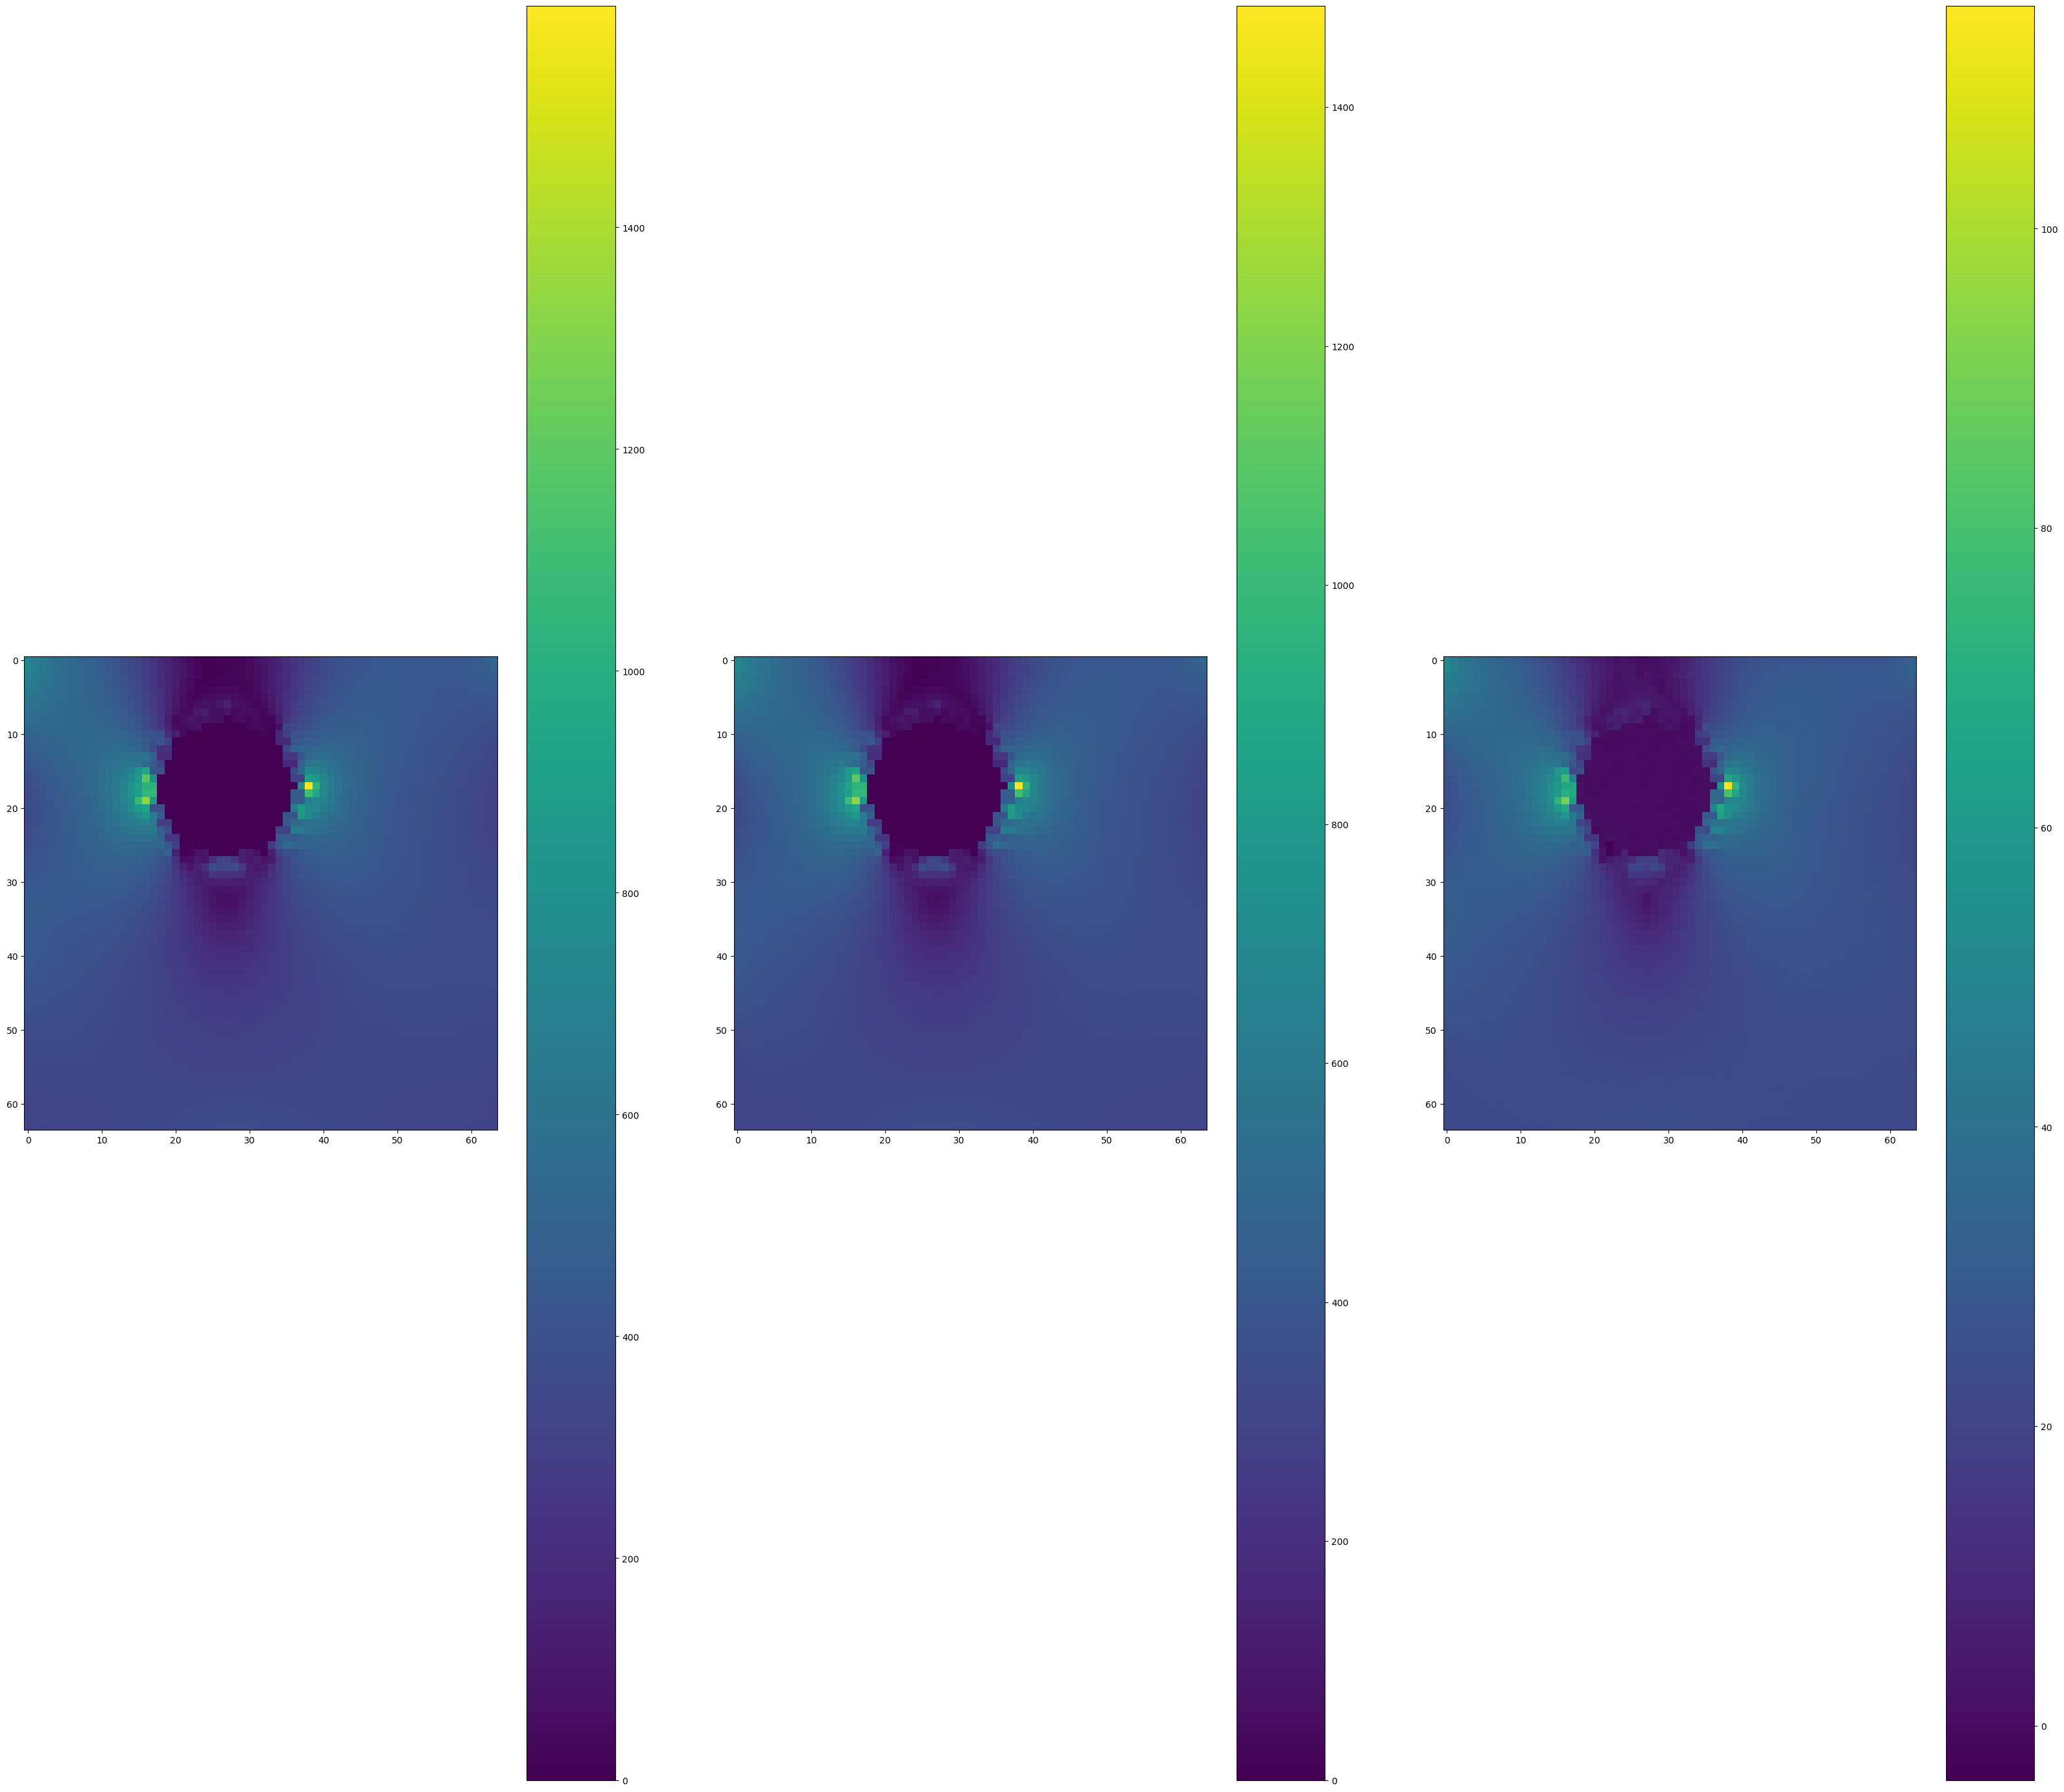

In [48]:
fig,ax=plt.subplots(1,3,figsize=(40,40))
c1=ax[0].imshow(pred_rs_uncale)
fig.colorbar(c1,ax=ax[0])

c2=ax[1].imshow(targets)
fig.colorbar(c2,ax=ax[1])

c3=ax[2].imshow(pred_rs_uncale-targets)
fig.colorbar(c3,ax=ax[2])

print("MAE: ",np.abs(pred_rs_uncale-targets).mean())
